In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer, Dense, LSTM, Input, RepeatVector, TextVectorization
import keras_tuner as kt
from keras.losses import mse, binary_crossentropy, mean_squared_error
from keras.models import Model
from keras import backend as K
from keras.preprocessing.text import Tokenizer
import pandas as pd
import seaborn as sns
import scipy

2023-01-24 12:37:18.905917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 12:37:18.905970: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-24 12:37:21.141560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-24 12:37:21.141766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-24 12:37:21.141780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [77]:
# import hydrophobic_moment

In [78]:
# from hydrophobic_moment import *

## DATA TIME - DBAASP

### GRAMPA - LEAVE this for a VM

In [119]:
with open("data/grampaReduced.csv", "r") as grampaFile:
    lines=grampaFile.readlines()

    grampaSequences = []
    for idx, string in enumerate(lines[1:]): # line 0 is header
        grampaSequences.append(string.split(",")[0].strip("\"")) # Clean strings
grampaSequences = list(set(grampaSequences))
# grampaSequences = [seq for seq in grampaSequences if "X" not in seq and "U" not in seq 
#                     and "Z" not in seq and "B" not in seq and "O" not in seq and "2" not in seq]
grampadf = pd.DataFrame(grampaSequences)
grampadf.rename(columns={0:"Sequence"}, inplace=True)
mask = grampadf["Sequence"].str.contains("[KLGARIVFSPCTWNHQYEDM]", case=False, regex=True) # Only standard aa's.

# Inversion of the mask allows us to look at the excluded sequences. 
mask = ~mask

# Use the mask to filter the dataframe
grampadf = grampadf[mask]


In [198]:
# grampadf["Sequence"][2816]

In [199]:
not_matching = []
aa_codes  = 'KLGARIVFSPCTWNHQYEDM'
for s in grampaSequences:
    for c in s:
        if c not in aa_codes:
            not_matching.append(s)
            grampaSequences.remove(s)
            break
not_matching

[]

In [200]:
# grampaSequences=  list(grampadf["Sequence"])

In [201]:
# grampaSequences[2816]

In [202]:
# for i, s in enumerate(grampaSequences):
#     if "8" in s:
#         print("The string '{}' contains the character '8' at index {}".format(s,i))

In [203]:
len(grampaSequences)

6754

In [48]:
# from random import shuffle

In [51]:
# shuffle(allSequences)
# allSequences[1:5]

[['LNWGAVLKHVVK', 'C. albicans'],
 ['QPRPPHPRL', 'S. pyogenes'],
 ['IRVKIRVKIRVK', 'S. epidermidis'],
 ['GILDTLKQFAKGVGKDLVKGAAQGVLSTVSCKLAKTC', 'C. albicans']]

In [64]:
# allSequencesdf = pd.DataFrame(allSequences)

In [65]:
# allSequencesdf.rename(columns={0:"Sequences", 1:"Species"}, inplace=True)

In [93]:
# allSequencesdf["Species"].value_counts()[0:20].sum()

38130

In [94]:
# allSequencesdf["Species"].value_counts()[0:20].sum() / len(allSequences)

0.7426234297399942

The 20 most commonly occurring species account for 74% of the observed data. This makes the problem substantially more tractable, by disregarding the other ~720 species that the model would have to learn to predict. 

This is sparse. There are a few ways to handle this:
1. Take the top x (say, 50) represented species & their associated AMP sequences)
2. use all data, but don't harshly penalize the model based on its prediction of species
    (we may be imposing too many different learning objectives if there are 700+ species represented)

### File Parsing (toy data, ~800 data points total)

In [7]:
with open("data/GramPosOnly.fasta", "r") as GramPosFile:
    lines = GramPosFile.readlines()

# print(lines)
gramPosSequences = []
for (idx, line) in enumerate(lines):
    if line[0]!="\n" and line[0]!=">":
        gramPosSequences.append(line.strip())
# for (idx,seq) in enumerate(gramPosSequences):
#     gramPosSequences[idx]= gramPosSequences[idx].strip()
print(gramPosSequences)

['NLCERASLTWTGNCGNTGHCDTQCRNWESAKHGACHKRGNWKCFCYFDC', 'VFIDILDKVENAIHNAAQVGIGFAKPFEKLINPK', 'GLFDIIKKIAESI', 'GLLNTFKDWAISIAKGAGKGVLTTLSCKLDKSC', 'GILDSFKQFAKGVGKDLIKGAAQGVLSTMSCKLAKTC', 'LLPILGNLLNGLL', 'VLPIIGNLLNSLL', 'LLPNLLKSLL', 'FLPFLAKILTGVL', 'FLPLFASLIGKLL', 'FLPFLASLLSKVL', 'FLPFLATLLSKVL', 'VLPLISMALGKLL', 'NFLGTLINLAKKIM', 'FLPILINLIHKGLL', 'FLPIVGKLLSGLL', 'GLFLDTLKGAAKDVAGKLEGLKCKITGCKLP', 'GFLDIINKLGKTFAGHMLDKIKCTIGTCPPSP', 'FLPFIARLAAKVFPSIICSVTKKC', 'HRHQGPIFDTRPSPFNPNQPRPGPIY', 'GFGCPLDQMQCHRHCQTITGRSGGYCSGPLKLTCTCYR', 'VGECVRGRCPSGMCCSQFGYCGKGPKYCGR', 'RGGRLCYCRRRFCVCVGR', 'CIGNGGRCNENVGPPYCCSGFCLRQPNQGYGVCRNR', 'QCIGNGGRCNENVGPPYCCSGFCLRQPGQGYGYCKNR', 'ITSISLCTPGCKTGALMGCNMKTATCNCSIHVSK', 'ITSISLCTPGCKTGALMGCNMKTATCHCSIHVSK', 'WKSESLCTPGCVTGALQTCFLQTLTCNCKISK', 'TAGPAIRASVKQCQKTLKATRLFTVSCKGKNGCK', 'RADTQTYQPYNKDWIKEKIYVLLRRQAQQAGK', 'ATCDLLSGTGINHSACAAHCLLRGNRGGYCNGKGVCVCRN', 'ATCDLLSGIGVQHSACALHCVFRGNRGGYCTGKGICVCRN', 'GLVSSIGRALGGLLADVVKSKEQPA', 'GLWQKIKDKASELVS

In [8]:
with open("data/GramNegOnly.fasta", "r") as GramNegFile:
    lines = GramNegFile.readlines()

# print(lines)
gramNegSequences = []
for (idx, line) in enumerate(lines):
    if line[0]!="\n" and line[0]!=">":
        gramNegSequences.append(line.strip())
for (idx,seq) in enumerate(gramNegSequences):
    gramNegSequences[idx]= gramNegSequences[idx].strip()
print(gramNegSequences)

['GNNRPVYIPQPRPPHPRL', 'RFRPPIRRPPIRPPFYPPFRPPIRPPIFPPIRPPFRPPLGPFP', 'DFASCHTNGGICLPNRCPGHMIQIGICFRPRVKCCRSW', 'QVVRNPQSCRWNMGVCIPISCPGNMRQIGTCFGPRVPCCRRW', 'GIGSAILSAGKSALKGLAKGLAEHFAN', 'GIGAAILSAGKSIIKGLANGLAEHF', 'GGLKKLGKKLEGVGKRVFKASEKALPVAVGIKALG', 'GWLKKIGKKIERVGQNTRDATVKGLEVAQQAANVAATVR', 'GLKKLLGKLLKKLGKLLLK', 'GRPNPVNNKPTPHPRL', 'GRPNPVNTKPTPYPRL', 'WYVKKCLNDVGICKKKCKPEEMHVKNGWAMCGKGRDCCVPAD', 'QLKKCWNNYVQGHCRKICRVNEVPEALCENGRYCCLNIKELEAC', 'GVLSNVIGYLKKLGTGALNAVLKQ', 'GLVSSIGRALGGLLADVVKSKGQPA', 'GCRFCCNCCPNMSGCGVCCRF', 'GNNRPIYIPQPRPPHPRL', 'QRFIHPTYRPPPQPRRPVIMRA', 'FFPIGVFCKIFKTC', 'VDKPDYRPRPRPPNM', 'VDKPDYRPRPWPRPN', 'VDKPDYRPRPWPRNMI', 'VDKPDYRPRPWPRPNM', 'GLVDVLGKVGGLIKKLLPG', 'SGFVLKGYTKTSQ', 'AGFVLKGYTKTSQ', 'GLMDTVKNAAKNLAGQMLDKLKCKITGSC', 'GCWSTVLGGLKKFAKGGLEAIVNPK', 'GVFLDALKKFAKGGMNAVLNPK', 'TWLKKRRWKKAKPP', 'FLPAIVGAAGQFLPKIFCAISKKC', 'FLPAIVGAAGKFLPKIFCAISKKC', 'FFPIVAGVAGQVLKKIYCTISKKC', 'GLNTLKKVFQGLHEAIKLINNHVQ', 'GLNALKKVFQGIHEAIKLINNHVQ', 'GINTLKKVIQGLH

In [89]:
len(gramPosSequences)+len(gramNegSequences)

804

In [404]:
len(grampaSequences)

6754

In [2]:
import random
import re
blacklist = re.compile("[U, X]")

In [9]:
# with open("data/uniprot.fasta", "r") as UniprotFile:
#     all_lines = UniprotFile.readlines()
# #     print(len(all_lines))
# #     print(type(all_lines))
#     random.shuffle(all_lines)
# lines = all_lines[0:1000]

# # print(lines)
# uniprotSequences = []

# for (idx, line) in enumerate(lines):
#     if line[0]!="\n" and line[0]!=">":
#         if blacklist.search(line) == None:
#             uniprotSequences.append(line.strip())
# # for (idx,seq) in enumerate(gramPosSequences):
# #     gramPosSequences[idx]= gramPosSequences[idx].strip()
# print(uniprotSequences)

['DKDENKLSEASGGRAENGERSDLEEDNEREGTENGAIDAVPVDENLFTGEDLDELEEELN', 'QSIVYPTIEKLGFQMTMLRKMAGGGILTAVSFFVCGIVQLFVNPTLPYIPMANEAHLTII', 'VDQEGGRVQRFRDGFTRLPAAQAFAALNSEPEALRLAEEGGWLMAAEMISMDIDISFAPV', 'PENSFIANDNTVRFSGTAAGYYDNRYWTMWKLPMFGCTDASQVLREISECRRAYPQCYVR', 'NVSDEAQEDERHYLMQPAQTSKWDDPWGEVLAWKFDPTPAYTYEAYVRYPEEFGSKSGLS', 'VYHGAGTRTIASPKGPVIQTYTNVDQDLVGWPAPQGSRSLTPCTCGSSDLYLVTRHADVI', 'FLALRDQVPTLASCSKAPKVVILSKALEYLQALVGAEKRMATEKRQLRCRQQQLQKRIAY', 'ARTERKTGVGYTGFACHYAPDVSLEDDLLRRDLTINAMAQDNSGQLIDPYGGQRDLAAKV', 'MSWSFLTRLLEEIHNHSTFVGKIWLTVLIVFRIVLTAVGGESIYYDEQSKFVCNTEQPGC', 'GNWFLEDDLASTVANYKATNDRKIEEIIGKGGERITSEQVDKLIKEGNNQISAEALSKVV', 'VPQGAGLSSSASLEVAVGTVFQQLYHLPLDGAQIALNGQEAENQFVGCNCGIMDQLISAL', 'ELPEPLFPYSFFEQFVEAIKKQDNNTRIEAVKSLVQKLPPPNRDTMKVLFGHLTKIVAKA', 'VGPNGVEPDLERDVVKVAVIERHGKNGNIATGFVHGFGLKAGAIASTVSHDSHNICVVGA', 'MHEFVTICIMAAALGMDAFSVALGMGMLKLSGKQIFRIGLTIGLFHVAMPLAGMAVGKWL', 'PEKKDSDKLSAGAIVGIVIGCVVGLLLLLLILFCLCRKRKKEENVPSRNVEAPVAAATSS', 'NTIKMGIMDEERRTTINLKECIRAARERVVFINTGFLD

In [ ]:
# mask = allSequencesdf["Sequence"].str.contains("[klgarivfspctwnhqyedm]", case=False, regex=True) # Only standard aa's.

# # Inversion of the mask allows us to look at the excluded sequences. 
# # mask = ~mask

# # Use the mask to filter the dataframe
# allSequencesdf = allSequencesdf[mask]
# data = allSequences

In [91]:
uniprotSequences = []
current_sequence = ""
max_lines = 40000
with open("data/uniprot.fasta", "r") as f:
    lines = f.readlines()[:max_lines]
    for line in lines:
        if line.startswith(">"):
            if current_sequence:
                uniprotSequences.append(current_sequence.upper())
            current_sequence = ""
        else:
            current_sequence += line.strip()
if current_sequence:
    uniprotSequences.append(current_sequence.upper())
uniprotSequences = [seq for seq in uniprotSequences if "X" not in seq and "U" not in seq 
                    and "Z" not in seq and "B" not in seq and "O" not in seq]


In [92]:
len(uniprotSequences)

2788

#### JOAO SCRIPT: Assign a series of scalar features (i.e., [seq, feature1, feature2])

In [10]:
# gramPosCharge = []
# gramPosHydrophobicity = [] #Mean (i.e., avg over whole sequence)
# gramPosHydrophobicMoment = [] 

# polar_aa = set(('S', 'T', 'N', 'H', 'Q', 'G'))
# speci_aa = set(('P', 'C'))
# apolar_aa = set(('A', 'L', 'V', 'I', 'M'))
# charged_aa = set(('E', 'D', 'K', 'R'))
# aromatic_aa = set(('W', 'Y', 'F'))

# gramPos_n_ps = []
# gramPos_n_ss = [] 
# gramPos_n_as = [] 
# gramPos_n_cs = [] 
# gramPos_n_ars = []
# for seq in gramPosSequences:
#     total_charge = hydrophobic_moment.calculate_charge(seq)
#     mean_uH = hydrophobic_moment.calculate_moment(hydrophobic_moment.assign_hydrophobicity(seq))
#     discrimination_factor = hydrophobic_moment.calculate_discrimination(mean_uH, total_charge)
    
#     gramPosHydrophobicity.append(sum(hydrophobic_moment.assign_hydrophobicity(seq))/len(seq))                                 
#     gramPosCharge.append(total_charge)
#     gramPosHydrophobicMoment.append(mean_uH)
                            

#     n_p, n_s, n_a, n_ar, n_c = 0, 0, 0, 0, 0
#     for aa in seq:
#         if aa in polar_aa:
#             n_p += 1
#         elif aa in speci_aa:
#             n_s += 1
#         elif aa in apolar_aa:
#             n_a += 1
#         elif aa in charged_aa:
#             n_c += 1
#         elif aa in aromatic_aa:
#             n_ar += 1       
#     gramPos_n_ps.append(n_p)
#     gramPos_n_ss.append(n_s)
#     gramPos_n_as.append(n_a)
#     gramPos_n_cs.append(n_c)
#     gramPos_n_ars.append(n_ar)
                                 

In [11]:
# gramPosdf = pd.DataFrame({
#     "gramPosHydrophobicity": gramPosHydrophobicity,
#     "gramPosCharge":gramPosCharge,
#     "gramPosHydrophobicMoment":gramPosHydrophobicMoment,
#     "gramPos_n_ps":gramPos_n_ps,
#     "gramPos_n_ss":gramPos_n_ss,
#     "gramPos_n_as":gramPos_n_as,
#     "gramPos_n_cs": gramPos_n_cs,
#     "gramPos_n_ars": gramPos_n_ars
# })

# gramPosdf

#### ModlAmp

In [93]:
from modlamp.descriptors import GlobalDescriptor

In [11]:
calc = GlobalDescriptor(gramPosSequences) # for gram positive sequences
calc.calculate_all()
descriptors = calc.descriptor # array shape: n_seqs x n_features

In [12]:
calcNeg = GlobalDescriptor(gramNegSequences) # for gram negative sequences 
calcNeg.calculate_all()
descriptorsNeg = calcNeg.descriptor

In [94]:
calcUniprot = GlobalDescriptor(uniprotSequences) # for gram negative sequences 
calcUniprot.calculate_all()
descriptorsUniprot = calcUniprot.descriptor

In [135]:
calcGrampa = GlobalDescriptor(grampaSequences) # for gram negative sequences 
calcGrampa.calculate_all()
descriptorsGrampa = calcGrampa.descriptor

In [95]:
calc.featurenames

['Length',
 'MW',
 'Charge',
 'ChargeDensity',
 'pI',
 'InstabilityInd',
 'Aromaticity',
 'AliphaticInd',
 'BomanInd',
 'HydrophRatio']

In [15]:
descDict = dict.fromkeys(range(0,10), "PASS")
for idx, elem in enumerate(calc.featurenames):
    descDict[idx]=elem
descDict

{0: 'Length',
 1: 'MW',
 2: 'Charge',
 3: 'ChargeDensity',
 4: 'pI',
 5: 'InstabilityInd',
 6: 'Aromaticity',
 7: 'AliphaticInd',
 8: 'BomanInd',
 9: 'HydrophRatio'}

In [385]:
uniprotdf = pd.DataFrame(descriptorsUniprot)
uniprotdf.rename(columns=descDict, inplace=True)

In [386]:
grampadf = pd.DataFrame(descriptorsGrampa)
grampadf.rename(columns=descDict, inplace=True)

In [387]:
gramPosdf = pd.DataFrame(descriptors)
gramPosdf.rename(columns=descDict, inplace=True)
gramPosdf = pd.concat([pd.DataFrame(gramPosSequences), gramPosdf],axis=1)
gramPosdf.rename(columns={0:"Sequence"}, inplace=True)
gramPosdf["gram"]=1 # gram Positive

In [388]:
gramNegdf = pd.DataFrame(descriptorsNeg)
gramNegdf.rename(columns=descDict, inplace=True)
gramNegdf = pd.concat([pd.DataFrame(gramNegSequences), gramNegdf],axis=1)
gramNegdf.rename(columns={0:"Sequence"}, inplace=True)
gramNegdf["gram"]=0 # Gram Negative


In [392]:
alldf = pd.concat((gramPosdf, gramNegdf))

# alldf.groupby(by="gram").mean()

In [393]:
grampadf.describe() # be mindful that after normalization (below) these values mean something different.

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
count,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000
mean,21.020580,2404.518844,4.838241,0.002376,11.852642,34.115618,0.122219,98.411871,1.330781,0.411089
std,13.750706,1477.672415,2.926329,0.001439,1.898803,53.282316,0.125678,54.169652,2.093785,0.160807
min,1.000000,74.090000,-10.805000,-0.007304,2.931641,-95.900000,0.000000,0.000000,-4.480000,0.000000
25%,12.000000,1489.155000,2.989000,0.001362,10.695862,2.554909,0.042857,60.000000,-0.085163,0.333333
50%,18.000000,2064.045000,4.680000,0.002234,12.403320,20.736136,0.090909,97.777778,0.955182,0.428571
75%,25.000000,2844.420000,6.199000,0.003309,13.265625,51.261538,0.160000,133.750000,2.499750,0.520000
max,190.000000,20732.520000,62.087000,0.013362,14.233398,486.777778,1.000000,340.000000,14.920000,1.000000


In [394]:
alldf.describe()

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio,gram
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,25.907960,2811.798694,3.291460,0.001228,10.408030,28.757496,0.090251,94.349221,0.650541,0.432255,0.649254
std,11.055345,1211.840139,2.480423,0.000922,2.050761,30.131190,0.069513,52.998953,1.641603,0.143284,0.477501
min,3.000000,300.320000,-5.009000,-0.006551,3.011230,-43.433333,0.000000,0.000000,-3.823333,0.000000,0.000000
25%,17.000000,1812.422500,1.989000,0.000733,8.978149,8.520089,0.041667,55.458494,-0.411825,0.333333,0.000000
50%,25.000000,2614.070000,2.989000,0.001206,10.594238,23.624506,0.078947,86.029412,0.691786,0.425000,1.000000
75%,35.250000,3871.560000,4.678250,0.001626,12.161133,42.916018,0.136364,127.692308,1.592229,0.523810,1.000000
max,49.000000,5613.260000,16.979000,0.005752,13.990234,163.589474,0.428571,260.000000,7.340000,0.875000,1.000000


In [395]:
uniprotdf.describe()

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
count,2788.000000,2.788000e+03,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000
mean,765.167145,8.512095e+04,-8.732079,-0.000062,6.838065,45.000820,0.081995,82.176617,1.676296,0.365704
std,972.101096,1.077688e+05,27.888846,0.000324,1.696488,11.875923,0.027237,14.314070,0.571730,0.051360
min,12.000000,1.404750e+03,-514.588000,-0.001941,3.184631,-7.400000,0.000000,0.000000,-1.237692,0.000000
25%,339.000000,3.793217e+04,-14.304250,-0.000212,5.545792,37.174115,0.064345,73.835029,1.344168,0.335523
50%,535.000000,5.985467e+04,-5.042000,-0.000078,6.437958,43.870383,0.080067,83.059936,1.675815,0.367647
75%,896.500000,9.990192e+04,2.903250,0.000057,7.999741,51.567032,0.097740,91.218850,1.983338,0.395215
max,35213.000000,3.906451e+06,137.788000,0.003366,13.582031,127.477087,0.250000,170.833333,5.051226,0.634783


### Normalize data

Data should be normalized when you are going to feed physicochemical descriptor values into a model (inc.plotting). Otherwise, molecular weight dominates the others due to its magnitude.

In [212]:
uniprotdf

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
0,307.280502,310.517295,9.713885,-1.253964,-1.087575,0.267146,-0.138392,-0.153666,0.451291,-0.321348
1,20.089109,19.071386,-5.671397,-1.783215,-2.973873,0.453814,-0.254202,0.008475,0.018805,0.022536
2,40.260347,38.652104,-4.442574,-1.501146,-2.644227,0.348393,0.076105,-0.370896,0.243076,-0.482941
3,40.893525,42.329033,-0.540013,-1.293188,-1.277785,0.191301,0.537506,0.151620,-0.033413,0.224591
4,60.341131,61.053450,-1.558388,-1.340427,-1.518323,0.540669,-0.177362,-0.277280,0.764066,-0.710531
...,...,...,...,...,...,...,...,...,...,...
2783,54.099807,55.775757,-0.577910,-1.303694,-1.299035,0.652968,0.177131,-0.038218,0.525931,-0.254192
2784,111.538085,117.266987,-11.159171,-1.514858,-2.043953,0.690241,0.061403,-0.266699,0.638138,-0.367023
2785,51.748003,53.545430,-6.151960,-1.524071,-2.178359,0.820621,0.024774,-0.301667,0.753451,-0.484204
2786,54.190261,57.427023,0.223567,-1.274703,-1.158498,0.140754,0.566061,0.064959,0.262896,-0.225112


In [397]:
gramPosdf = gramPosdf.drop(["gram","Sequence"], axis=1)
gramNegdf = gramNegdf.drop(["gram","Sequence"], axis=1)
# uniprotdf = uniprotdf.drop(["gram","Sequence"], axis=1) # I don't think gram or sequence were defined anyway

# gramPosdf = gramPosdf.drop(["Sequence"], axis=1)
# gramNegdf = gramNegdf.drop(["Sequence"], axis=1)
# uniprotdf = uniprotdf.drop(["Sequence"], axis=1)


In [398]:
alldf = pd.concat((gramPosdf, gramNegdf))

# alldf.groupby(by="gram").mean()

In [138]:
grampadf.describe() # be mindful 

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
count,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000
mean,21.020580,2404.518844,4.838241,0.002376,11.852642,34.115618,0.122219,98.411871,1.330781,0.411089
std,13.750706,1477.672415,2.926329,0.001439,1.898803,53.282316,0.125678,54.169652,2.093785,0.160807
min,1.000000,74.090000,-10.805000,-0.007304,2.931641,-95.900000,0.000000,0.000000,-4.480000,0.000000
25%,12.000000,1489.155000,2.989000,0.001362,10.695862,2.554909,0.042857,60.000000,-0.085163,0.333333
50%,18.000000,2064.045000,4.680000,0.002234,12.403320,20.736136,0.090909,97.777778,0.955182,0.428571
75%,25.000000,2844.420000,6.199000,0.003309,13.265625,51.261538,0.160000,133.750000,2.499750,0.520000
max,190.000000,20732.520000,62.087000,0.013362,14.233398,486.777778,1.000000,340.000000,14.920000,1.000000


In [64]:
alldf.describe()

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,25.907960,2811.798694,3.291460,0.001228,10.408030,28.757496,0.090251,94.349221,0.650541,0.432255
std,11.055345,1211.840139,2.480423,0.000922,2.050761,30.131190,0.069513,52.998953,1.641603,0.143284
min,3.000000,300.320000,-5.009000,-0.006551,3.011230,-43.433333,0.000000,0.000000,-3.823333,0.000000
25%,17.000000,1812.422500,1.989000,0.000733,8.978149,8.520089,0.041667,55.458494,-0.411825,0.333333
50%,25.000000,2614.070000,2.989000,0.001206,10.594238,23.624506,0.078947,86.029412,0.691786,0.425000
75%,35.250000,3871.560000,4.678250,0.001626,12.161133,42.916018,0.136364,127.692308,1.592229,0.523810
max,49.000000,5613.260000,16.979000,0.005752,13.990234,163.589474,0.428571,260.000000,7.340000,0.875000


In [65]:
uniprotdf.describe()

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
count,1825.000000,1.825000e+03,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,729.385753,8.109274e+04,-8.516499,-0.000074,6.802060,45.032385,0.082261,82.073469,1.677981,0.365758
std,1055.009542,1.167784e+05,28.512327,0.000279,1.661649,12.049877,0.026817,14.196667,0.578892,0.052393
min,16.000000,2.173610e+03,-514.588000,-0.001941,3.184631,8.113836,0.005444,0.000000,-1.190348,0.000000
25%,337.000000,3.763918e+04,-13.677000,-0.000213,5.527344,37.205229,0.064343,73.864542,1.356633,0.334816
50%,507.000000,5.699254e+04,-4.998000,-0.000081,6.424561,43.890349,0.080495,83.019663,1.690464,0.366871
75%,832.000000,9.265612e+04,2.771000,0.000054,7.997314,51.600234,0.097710,90.996310,1.985611,0.395349
max,35213.000000,3.906451e+06,116.798000,0.001981,12.422852,127.477087,0.250000,154.260870,4.931801,0.634783


In [259]:
uniprotdf = (uniprotdf-alldf.mean())/alldf.std()
grampadf = (grampadf-alldf.mean())/alldf.std()

gramPosdf= (gramPosdf-alldf.mean())/alldf.std()
# gramPosdf["gram"]=1 # comment out, if you drop gram above
gramNegdf= (gramNegdf-alldf.mean())/alldf.std()
# gramNegdf["gram"]=0 # comment out, if you drop gram above
alldf = pd.concat((gramPosdf, gramNegdf)) # post standardization


### Statistics / Characterization

In [399]:
# rng = np.random.default_rng()
t_tests = scipy.stats.ttest_ind(gramPosdf, gramNegdf, equal_var=False)
total_t_tests = scipy.stats.ttest_ind(grampadf, uniprotdf, equal_var=False) # fails if gram is included in alldf

In [400]:
total_t_tests

Ttest_indResult(statistic=array([-40.41806318, -40.52548964,  25.63428724, 131.36557844,
       126.71268954, -15.86198518,  24.92331055,  22.77968332,
       -12.48126309,  20.77002449]), pvalue=array([1.59815399e-281, 1.03306054e-282, 2.01433596e-130, 0.00000000e+000,
       0.00000000e+000, 7.83700632e-056, 3.49967439e-132, 1.35636683e-111,
       1.89519753e-035, 1.14526541e-093]))

In [1323]:
# descDict = dict.fromkeys(range(0,10), "PASS")
# for idx, elem in enumerate(calc.featurenames):
#     descDict[idx]=elem
# descDict
# list(gramPosdf.drop(["gram","Sequence"], axis=1).columns)

In [401]:
# Gram pos vs gram neg AMPs
statsdf = pd.DataFrame({"t_statistic": t_tests[0], "p_value": t_tests[1]})
statsdf.rename(index=descDict)

,t_statistic,p_value
Length,-0.730540,4.653184e-01
MW,-1.055979,2.913566e-01
Charge,-5.239314,2.371614e-07
ChargeDensity,-4.405952,1.354009e-05
pI,-2.013716,4.446612e-02
InstabilityInd,0.470094,6.384925e-01
Aromaticity,3.333607,9.167595e-04
AliphaticInd,3.749802,1.903374e-04
BomanInd,-8.435400,2.375319e-16
HydrophRatio,6.216365,9.436199e-10


In [402]:
# All AMPs vs All Proteins
totalStatsdf = pd.DataFrame({"t_statistic": total_t_tests[0], "p_value": total_t_tests[1]})
totalStatsdf.rename(index=descDict)

,t_statistic,p_value
Length,-40.418063,1.598154e-281
MW,-40.525490,1.033061e-282
Charge,25.634287,2.014336e-130
ChargeDensity,131.365578,0.000000e+00
pI,126.712690,0.000000e+00
InstabilityInd,-15.861985,7.837006e-56
Aromaticity,24.923311,3.499674e-132
AliphaticInd,22.779683,1.356367e-111
BomanInd,-12.481263,1.895198e-35
HydrophRatio,20.770024,1.145265e-93


### Gram Negative Sequences

##### Assign a series of scalar features (i.e., [seq, feature1, feature2])
gramNegCharge = []
gramNegHydrophobicity = [] #Mean (i.e., avg over whole sequence)
gramNegHydrophobicMoment = [] 

polar_aa = set(('S', 'T', 'N', 'H', 'Q', 'G'))
speci_aa = set(('P', 'C'))
apolar_aa = set(('A', 'L', 'V', 'I', 'M'))
charged_aa = set(('E', 'D', 'K', 'R'))
aromatic_aa = set(('W', 'Y', 'F'))

gramNeg_n_ps = []
gramNeg_n_ss = [] 
gramNeg_n_as = [] 
gramNeg_n_cs = [] 
gramNeg_n_ars = []
for seq in gramNegSequences:
    total_charge = hydrophobic_moment.calculate_charge(seq)
    mean_uH = hydrophobic_moment.calculate_moment(hydrophobic_moment.assign_hydrophobicity(seq))
    discrimination_factor = hydrophobic_moment.calculate_discrimination(mean_uH, total_charge)
    
    gramNegHydrophobicity.append(sum(hydrophobic_moment.assign_hydrophobicity(seq))/len(seq))                                 
    gramNegCharge.append(total_charge)
    gramNegHydrophobicMoment.append(mean_uH)
                            

    n_p, n_s, n_a, n_ar, n_c = 0, 0, 0, 0, 0
    for aa in seq:
        if aa in polar_aa:
            n_p += 1
        elif aa in speci_aa:
            n_s += 1
        elif aa in apolar_aa:
            n_a += 1
        elif aa in charged_aa:
            n_c += 1
        elif aa in aromatic_aa:
            n_ar += 1       
    gramNeg_n_ps.append(n_p)
    gramNeg_n_ss.append(n_s)
    gramNeg_n_as.append(n_a)
    gramNeg_n_cs.append(n_c)
    gramNeg_n_ars.append(n_ar)
                                 

gramNegdf = pd.DataFrame({
    "gramNegHydrophobicity": gramNegHydrophobicity,
    "gramNegCharge":gramNegCharge,
    "gramNegHydrophobicMoment":gramNegHydrophobicMoment,
    "gramNeg_n_ps":gramNeg_n_ps,
    "gramNeg_n_ss":gramNeg_n_ss,
    "gramNeg_n_as":gramNeg_n_as,
    "gramNeg_n_cs": gramNeg_n_cs,
    "gramNeg_n_ars": gramNeg_n_ars
})

gramNegdf

gramPosdf.describe()

gramNegdf.describe()

gramPosdf.std()/gramPosdf.mean()

gramNegdf.std()/gramNegdf.mean()

gramNegdf["Length"].max()

### Visualizing gram pos and gram neg sequences with t-SNE

In [268]:
from sklearn.manifold import TSNE

In [269]:
import matplotlib.pyplot as plt

In [291]:
tsne = TSNE(n_components=2, verbose=1, learning_rate=2,perplexity=90, 
            min_grad_norm=1e-12, random_state=1, init="pca", n_iter=250, angle=.25)

In [271]:
# alldfTsne = tsne.fit_transform(alldf.drop(["gram","Sequence"], axis=1))

In [222]:
gramPosdfTsne = tsne.fit_transform(gramPosdf)
gramNegdfTsne = tsne.fit_transform(gramNegdf)

ValueError: n_iter should be at least 250

In [293]:
%%time
# uniprotdfTsne = tsne.fit_transform(uniprotdf)
# alldfTsne = tsne.fit_transform(alldf)

total_df = pd.concat([uniprotdf, grampadf], axis=0)
total_df_tsne = tsne.fit_transform(total_df)

uniprot_tsne = total_df_tsne[:len(uniprotdf),:]
grampa_tsne = total_df_tsne[len(uniprotdf):,:]



[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 9542 samples in 0.020s...
[t-SNE] Computed neighbors for 9542 samples in 1.428s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9542
[t-SNE] Computed conditional probabilities for sample 2000 / 9542
[t-SNE] Computed conditional probabilities for sample 3000 / 9542
[t-SNE] Computed conditional probabilities for sample 4000 / 9542
[t-SNE] Computed conditional probabilities for sample 5000 / 9542
[t-SNE] Computed conditional probabilities for sample 6000 / 9542
[t-SNE] Computed conditional probabilities for sample 7000 / 9542
[t-SNE] Computed conditional probabilities for sample 8000 / 9542
[t-SNE] Computed conditional probabilities for sample 9000 / 9542
[t-SNE] Computed conditional probabilities for sample 9542 / 9542
[t-SNE] Mean sigma: 1.002891


/home/monad/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.993675
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


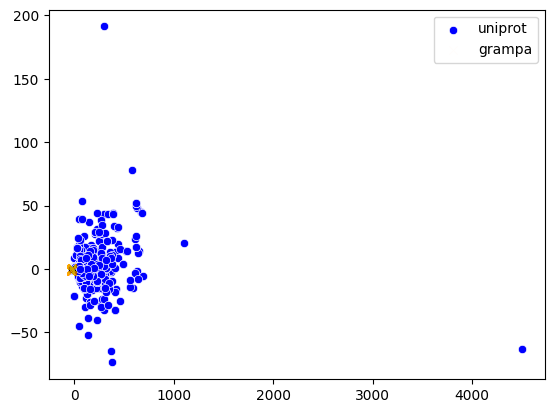

In [321]:
sns.scatterplot(x=uniprot_tsne[:,0], y=uniprot_tsne[:,1],color='blue', marker='o', label='uniprot')
sns.scatterplot(x=grampa_tsne[:,0], y=grampa_tsne[:,1],color='orange', marker='x', 
                label='grampa',alpha=.02, sizes=5)

# plt.xlim(-30,-25)
# plt.ylim(-500,500)
plt.show()


In [1332]:
# gramNegdf.drop(["gram","Sequence"], axis=1).iloc[0:2]

In [1258]:
mysterydf = gramPosdf.copy() # USE COPY, not EQUATE
mysterydf["Length"]=2
# mysterydf["MW"]=mysterydf["MW"]+50
# mysterydf["pI"]=mysterydf["pI"]*1.5
# mysterydf["Aromaticity"]=mysterydf["Aromaticity"]*3

# mysterydf

In [1259]:
miniTsne = tsne.fit_transform(mysterydf.iloc[0:140])
# a random sample of 40 sequences from the gram neg space.

[t-SNE] Computing 139 nearest neighbors...
[t-SNE] Indexed 140 samples in 0.000s...
[t-SNE] Computed neighbors for 140 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 140 / 140
[t-SNE] Mean sigma: 2.449547


/home/monad/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 27.664394
[t-SNE] KL divergence after 1000 iterations: 0.047502


In [1260]:
# alldfTsne = pd.concat((gramPosdfTsne, gramNegdfTsne))

<AxesSubplot: >

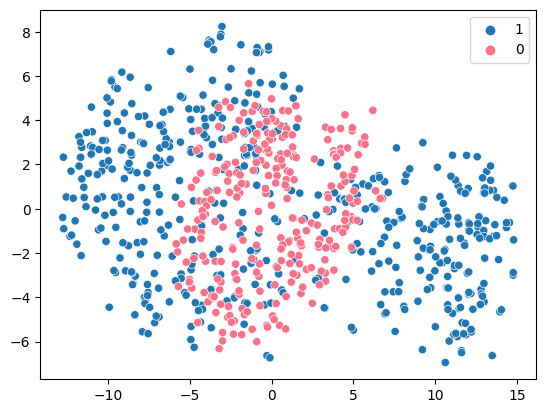

In [1400]:
# plt.figure(figsize=(16,10))
sns.scatterplot(
    #x="tsne-2d-one", y="tsne-2d-two",
#     hue="b",
    x=gramPosdfTsne[:,0],
    y=gramPosdfTsne[:,1],
    legend="auto",
    alpha=1,
    hue=1,
    palette="tab10"
)

sns.scatterplot(
    #x="tsne-2d-one", y="tsne-2d-two",
#     hue="b",
    x=gramNegdfTsne[:,0],
    y=gramNegdfTsne[:,1],    
    legend="auto",
    hue=0,
    alpha=1,
    palette="husl"
)
# sns.scatterplot(
#     #x="tsne-2d-one", y="tsne-2d-two",
# #     hue="b",
#     x=miniTsne[:,0],
#     y=miniTsne[:,1],    
#     legend="auto",
#     hue=0,
#     alpha=.4
# )


<AxesSubplot: >

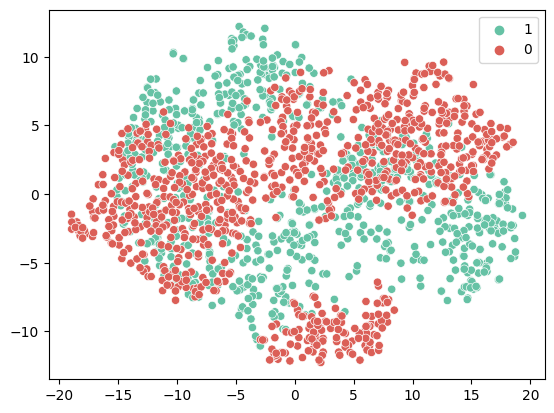

In [1390]:
# PLotting






sns.scatterplot(
    x=alldfTsne[:,0],
    y=alldfTsne[:,1],    
    legend="auto",
    alpha=1,
    hue=1,
    palette="Set2"
)
sns.scatterplot(
    x=uniprotdfTsne[:,0],
    y=uniprotdfTsne[:,1],    
    legend="auto",
    alpha=1,
    hue=0,
    palette="hls"
)



In [1334]:
uniprotdf

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
0,3.083761,3.351177,-0.527112,-1.019201,-0.314918,0.423841,0.140245,-0.094641,0.589744,-0.341431
1,3.083761,3.838436,1.106078,-0.455218,0.194908,2.162073,-0.579040,-0.607230,2.841203,-0.690389
2,3.083761,2.843800,0.296538,-0.634326,0.187467,-0.141796,-0.099517,-0.242443,0.442327,-0.108793
3,3.083761,2.755505,-0.525499,-0.981749,-0.228013,-0.632816,-0.579040,0.084608,0.197648,-0.108793
4,3.083761,3.283561,-0.523887,-1.014145,0.063895,0.477717,-1.058563,0.458829,0.836860,0.240165
...,...,...,...,...,...,...,...,...,...,...
858,3.083761,3.250743,4.309564,0.913972,0.804259,-0.854071,-0.099517,0.178949,0.398062,-0.108793
859,3.083761,3.114455,-4.662698,-2.695020,-3.327209,0.948381,0.140245,-0.644967,0.684875,-1.155666
860,3.083761,3.081860,-0.508567,-0.995969,-0.103250,0.078407,-0.579040,0.700972,0.508421,0.240165
861,3.083761,3.185760,-1.519685,-1.410025,-2.046602,-0.132393,0.380006,-0.553770,0.806402,-0.806708


### Using PCA 

In [326]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver="full")
# pca.fit(alldf.drop(["gram","Sequence"], axis=1))
pca.fit(alldf)
# pca.fit(normalizedAlldf)

gramPosdfPca = pca.transform(gramPosdf)
gramNegdfPca = pca.transform(gramNegdf)
# gramPosdfPca = pca.transform(normalizedGramPosdf)
# gramNegdfPca = pca.transform(normalizedGramNegdf)
pca.explained_variance_ratio_
# pca.components_[0]

array([0.37621025, 0.23222734])

In [375]:
total_df.drop(["Length","MW"],axis=1)

,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
0,9.713885,-1.253964,-1.087575,0.267146,-0.138392,-0.153666,0.451291,-0.321348
1,-5.671397,-1.783215,-2.973873,0.453814,-0.254202,0.008475,0.018805,0.022536
2,-4.442574,-1.501146,-2.644227,0.348393,0.076105,-0.370896,0.243076,-0.482941
3,-0.540013,-1.293188,-1.277785,0.191301,0.537506,0.151620,-0.033413,0.224591
4,-1.558388,-1.340427,-1.518323,0.540669,-0.177362,-0.277280,0.764066,-0.710531
...,...,...,...,...,...,...,...,...
6749,1.909570,2.201657,1.393431,-0.920889,1.578814,-0.214140,0.241812,-0.225112
6750,-1.733761,-2.036767,-2.904705,0.637116,2.625047,-1.780209,2.329434,-1.747837
6751,-0.927850,3.702601,0.898189,2.407555,-1.298325,0.955694,-1.626789,0.472804
6752,0.279606,1.008892,0.235801,-0.636909,1.578814,0.546881,-0.319530,-0.225112


In [342]:
total_df.drop(["Length","MW"],axis=1).columns


Index(['Charge', 'ChargeDensity', 'pI', 'InstabilityInd', 'Aromaticity',
       'AliphaticInd', 'BomanInd', 'HydrophRatio'],
      dtype='object')

In [352]:
new_cols = {
    0:'Charge',
    1:'ChargeDensity',
    2: 'pI',
    3:'InstabilityInd',
    4:'Aromaticity',
    5:'AliphaticInd',
    6:'BomanInd',
    7:'HydrophRatio'
}

In [382]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver="full")
pca.fit(total_df)
pca.fit(total_df.drop(["Length","MW"],axis=1))

# uniprot_pca = pca.transform(uniprotdf)
# grampa_pca = pca.transform(grampadf)
uniprot_pca = pca.transform(uniprotdf.drop(["Length","MW"],axis=1))
grampa_pca = pca.transform(grampadf.drop(["Length","MW"],axis=1))

pca.explained_variance_ratio_
# pca.components_[0]

array([0.7919408 , 0.07840908])

In [383]:
total_df.describe()

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
count,9542.000000,9542.000000,9542.000000,9542.000000,9542.000000,9542.000000,9542.000000,9542.000000,9542.000000,9542.000000
mean,19.224981,19.607345,-0.974923,0.472586,-0.010024,0.283380,0.290803,-0.012849,0.475872,-0.240267
std,56.539511,57.226135,6.641063,1.791108,1.429464,1.511837,1.558104,0.883243,1.093621,0.974566
min,-2.253024,-2.259134,-208.786790,-9.255412,-3.645665,-4.137158,-1.298325,-1.780209,-3.125324,-3.016774
25%,-1.077122,-0.900836,-0.911321,-1.246142,-1.171296,-0.663736,-0.541183,-0.502971,-0.193555,-0.690389
50%,-0.172583,-0.127342,0.280815,0.286882,0.262944,0.194221,-0.099517,-0.099007,0.464870,-0.270242
75%,20.790128,20.905174,1.087936,1.724734,1.302002,0.751591,0.601976,0.475410,0.949287,0.360237
max,3182.812586,3221.249154,54.223237,13.161512,1.865341,15.200869,13.087372,4.635012,8.692395,3.962381


In [384]:
pd.DataFrame(pca.components_[1]).T.rename(columns=new_cols)

,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
0,-0.102289,0.546382,0.330548,0.432752,0.433367,-0.187357,0.329171,-0.251407


In [303]:
totalStatsdf.T.rename(columns=descDict)

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
t_statistic,-4.041806e+01,-4.052549e+01,2.563429e+01,131.365578,126.71269,-1.586199e+01,2.492331e+01,2.277968e+01,-1.248126e+01,2.077002e+01
p_value,1.598154e-281,1.033061e-282,2.014336e-130,0.000000,0.00000,7.837006e-56,3.499674e-132,1.356367e-111,1.895198e-35,1.145265e-93


<AxesSubplot: >

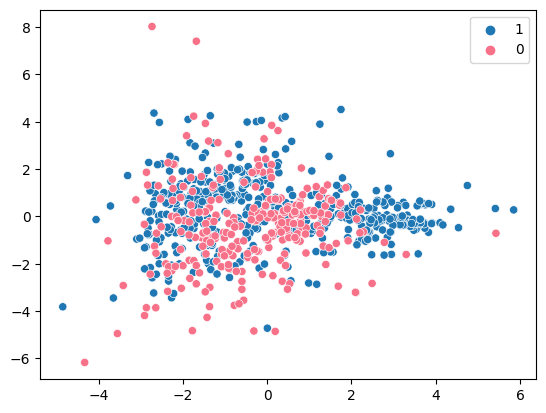

In [327]:
# plt.figure(figsize=(16,10))
sns.scatterplot(
    #x="Pca-2d-one", y="Pca-2d-two",
#     hue="b",
    x=gramPosdfPca[:,0],
    y=gramPosdfPca[:,1],
    legend="auto",
    alpha=1,
    hue=1,
    palette="tab10"
)

sns.scatterplot(
    #x="Pca-2d-one", y="Pca-2d-two",
#     hue="b",
    x=gramNegdfPca[:,0],
    y=gramNegdfPca[:,1],    
    legend="auto",
    hue=0,
    alpha=1,
    palette="husl"
)

<AxesSubplot: >

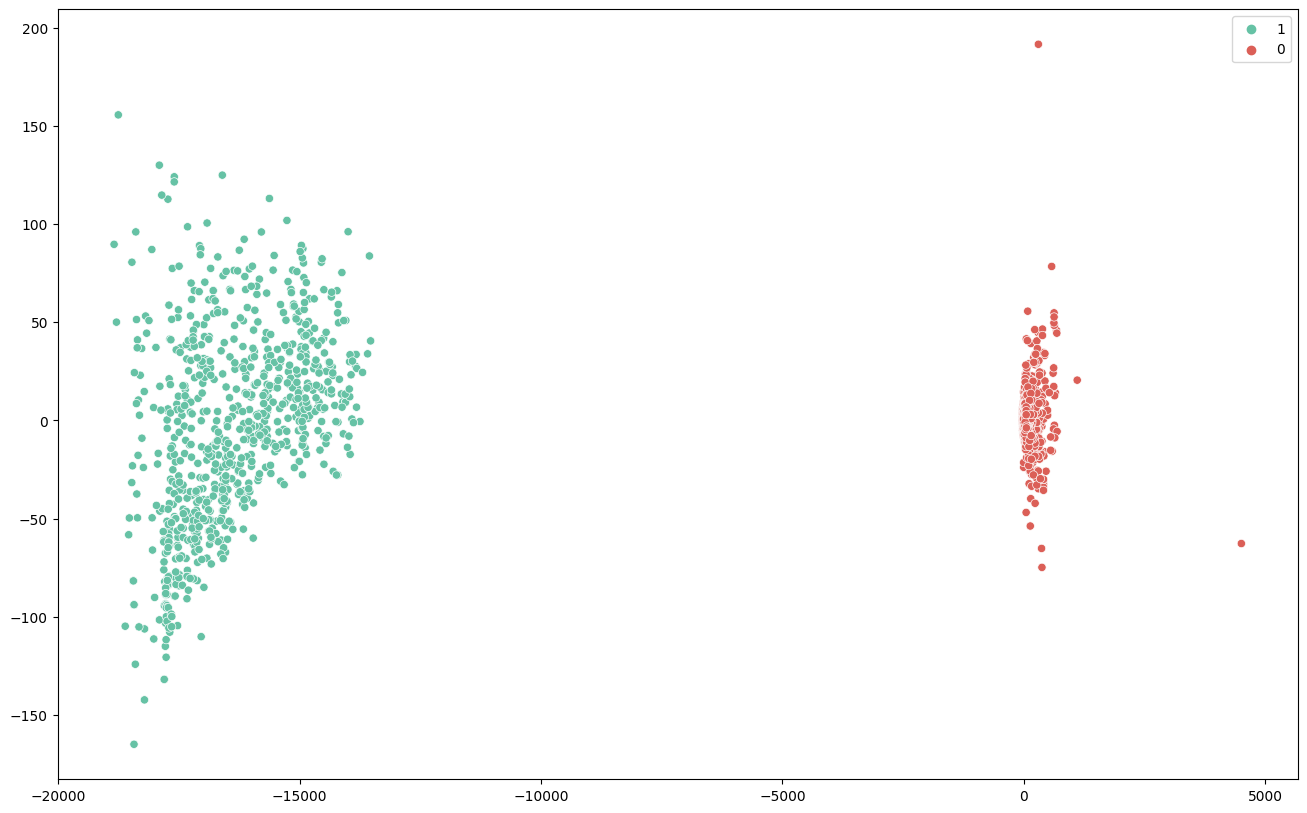

In [324]:
plt.figure(figsize=(16,10))

# sns.scatterplot(
#     x=alldfPca[:,0],
#     y=alldfPca[:,1],    
#     legend="auto",
#     alpha=1,
#     hue=1,
#     palette="Set2"
# )
sns.scatterplot(
    x=uniprot_pca[:,0],
    y=uniprot_pca[:,1],    
    legend="auto",
    alpha=1,
    hue=0,
    palette="hls"
)


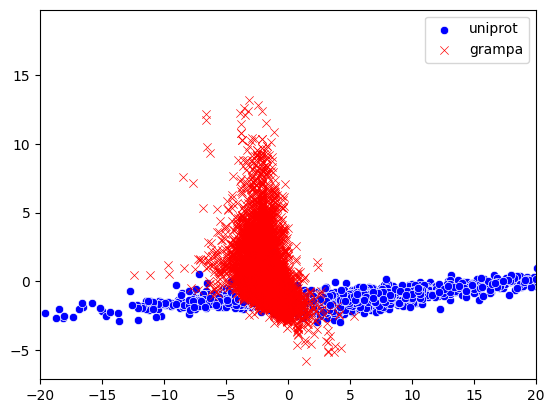

In [368]:
sns.scatterplot(x=uniprot_pca[:,0], y=uniprot_pca[:,1],color='blue', marker='o', label='uniprot')
sns.scatterplot(x=grampa_pca[:,0], y=grampa_pca[:,1],color='red', marker='x', 
                label='grampa',alpha=1, sizes=5)

# plt.xlim(-32,500)
plt.xlim(-20,20)

# plt.ylim(-200,200)
plt.show()


### Using DBSCAN instead of t-SNE

In [1153]:
from sklearn.cluster import DBSCAN

In [1154]:
dbscan = DBSCAN(min_samples=4, leaf_size=30, p=2)

In [1155]:
gramAlldfDbscan = dbscan.fit(alldf)
# gramPosdfPredict = dbscan.predict(gramPosdf)
gramAlldfDbscan.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1,  0, -1,  0,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [1156]:
gramPosdfDbscan = dbscan.fit_transform(gramPosdf)
gramNegdfDbscan = dbscan.fit_transform(gramNegdf)

plt.figure(figsize=(16,10))
sns.scatterplot(
    #x="Dbscan-2d-one", y="Dbscan-2d-two",
#     hue="b",
    x=gramPosdfDbscan[:,0],
    y=gramPosdfDbscan[:,1],
    legend="auto",
    alpha=1
)
sns.scatterplot(
    #x="Dbscan-2d-one", y="Dbscan-2d-two",
#     hue="b",
    x=gramNegdfDbscan[:,0],
    y=gramNegdfDbscan[:,1],    
    legend="auto",
    alpha=1
)


AttributeError: 'DBSCAN' object has no attribute 'fit_transform'

## K-means clustering

In [1339]:
from sklearn.cluster import KMeans

In [1340]:
# reducedAlldf = alldf.drop(["Length","MW","Charge","ChargeDensity", "pI", "InstabilityInd","Aromaticity",
#                           'AliphaticInd', 'BomanInd', 'HydrophRatio'], axis=1)
# reducedAlldf

In [1350]:
kmeans = KMeans(n_clusters=2, max_iter=2000, random_state=90, n_init=1)
# kmeans.fit(alldf.sample(frac=1)) # gram pos vs gram neg
kmeans.fit(uniprotdf.sample(frac=1)) # all amps vs all peptides

# gramPosdfKmeans = kmeans.transform(gramPosdf)
# gramNegdfKmeans = kmeans.transform(gramNegdf)
alldfKmeans = kmeans.transform(alldf)
uniprotdfKmeans = kmeans.transform(uniprotdf)
kmeans.predict(uniprotdf)

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,

<AxesSubplot: >

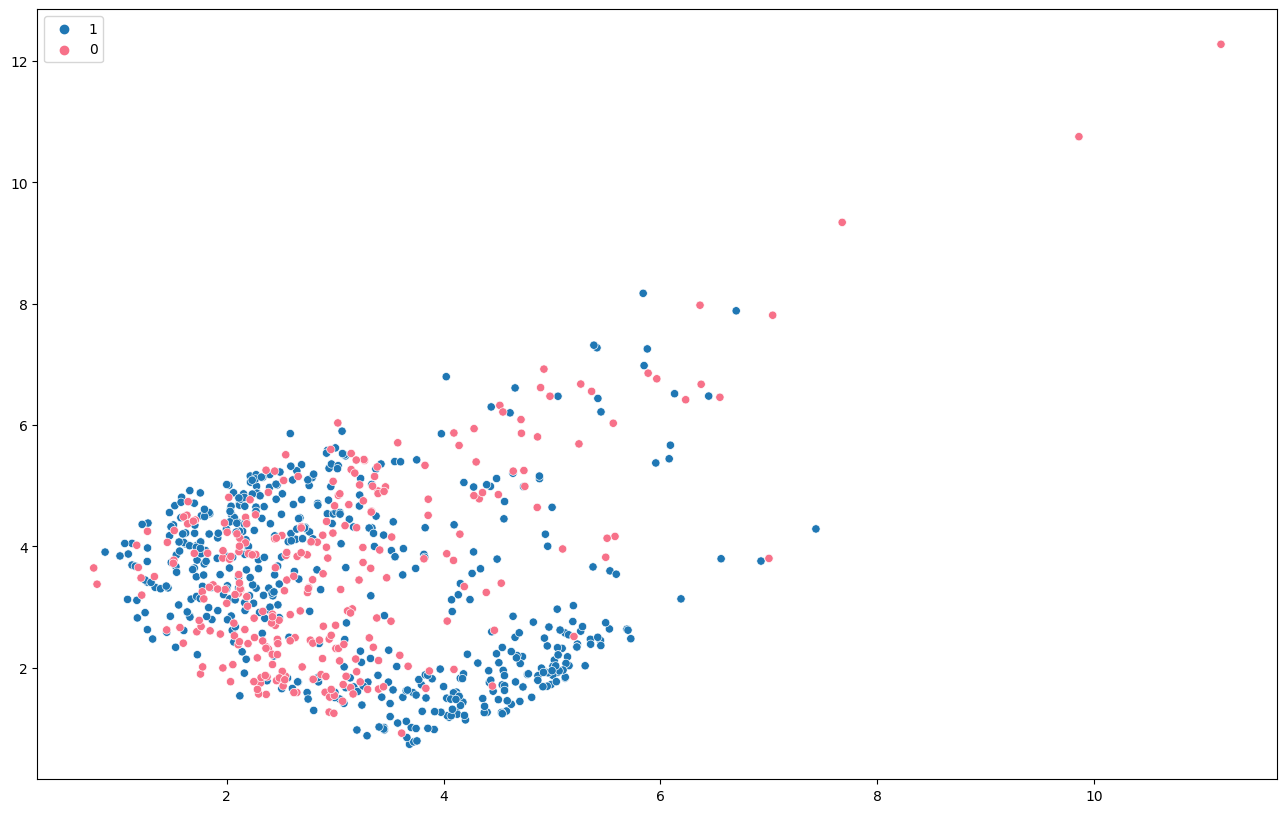

In [1404]:
plt.figure(figsize=(16,10))
# sns.scatterplot(
#     #x="Kmeans-2d-one", y="Kmeans-2d-two",
# #     hue="b",
#     x=gramPosdfKmeans[:,0],
#     y=gramPosdfKmeans[:,1],
#     legend="auto",
#     alpha=1
# )
# sns.scatterplot(
#     #x="Kmeans-2d-one", y="Kmeans-2d-two",
# #     hue="b",
#     x=gramNegdfKmeans[:,0],
#     y=gramNegdfKmeans[:,1],    
#     legend="auto",
#     alpha=1
# )



sns.scatterplot(
    #x="Kmeans-2d-one", y="Kmeans-2d-two",
#     hue="b",
    x=gramPosdfKmeans[:,0],
    y=gramPosdfKmeans[:,1],
    legend="auto",
    alpha=1,
    hue=1,
    palette="tab10"
)

sns.scatterplot(
    #x="Kmeans-2d-one", y="Kmeans-2d-two",
#     hue="b",
    x=gramNegdfKmeans[:,0],
    y=gramNegdfKmeans[:,1],    
    legend="auto",
    hue=0,
    alpha=1,
    palette="husl"
)


## Lessons
We've learned that:

#### alldf vs uniprotdf
* t-test reveals strong statistical differences across nearly all parameters. 
* alldf is a subset of uniprotdf (as expected), and we see that it clusters among itself.
* the top component of alldf vs uniprotdf PCA captures 100% of the variance. 
    ** How does this feature vector project onto the others? See pca.components_[:,0] **


#### gram pos vs gram neg
* t-test reveals strong statistical differences across nearly all parameters. 
* in each visualization, the two clusters begin to diverge from one another but ARE NOT completely resolved!!
* PCA top two components capture  ~37.6 and 23% of the variance respectively. Not close to 100%.


Perhaps due to inherent variance of AMP properties, it appears that gram pos vs gram negative are not completely resolved in 2D space. This is despite the fact that their means are significantly different across multiple features via t-test


### DBAASP data exploration

Broad Purpose: To understand and characterize sequence similarities.\
\
    More specifically, I want to evaluate the following question: how selective are AMPs? Are gram- and gram+ sequences substantially different, and what features of the sequence display the greatest difference between groups?
    
Query criteria: Gram- (may or may not be gram)+, length <50, 
  

In [8]:
# pre_x= [KDARDHN, RNLIVD,...] from FASTA lines
# x = [[0 1 0 0.... 0], [0 0 0 ... 1 ..]] from 
# create the tokenizer
# pre_x = ["ABCD", "BCDE"]
# t = Tokenizer()
# t.fit_on_texts(pre_x)
# x = t.texts_to_matrix(pre_x, mode='binary')

# print(x)

[[0. 1. 0.]
 [0. 0. 1.]]


## Preparing data for input into model

### Toy Example

In [33]:
from keras.layers import TextVectorization

pre_x = ["ABCD", "BCDE"]
pre_x_2 = [["ABCD"], ["BCDE"]]
pre_x_3 = [["A", "B", "C", "D"], ["E", "B", "C", "D"]]
vocabulary=["A", "B", "C", "D", "E"]

vectorize_layer = TextVectorization(standardize=None, output_mode="multi_hot", 
                                    split="character", vocabulary=vocabulary)
#vectorize_layer.adapt(vocabulary)
print(vectorize_layer.get_vocabulary())

for x in pre_x:
    print(x)
    vec = vectorize_layer(x)
    print(vec)


for seq in alldf["Sequence"]:
    print(seq)

['LSHCLLVTLAATPAVHATVLTSKYR',
 'HCLLVHLPAEFTPAVHASLDKSTVLTSKYR',
 'AHLPAEFTPAVHFLASVSTVLTSKYR',
 'MVHLTPEEKSAVHASASVSTVLTSKYR']

### Method 1 - CORRECT

#### aa's

In [73]:
# REPLACE WITH ACTUAL DATA!!!!!
data = allSequences
# [("LSHCLLVTLAATPAVHATVLTSKYR", "Homo sapiens"),
#         ("HCLLVHLPAEFTPAVHASLDKSTVLTSKYR", "Pan troglodytes"),
#         ("AHLPAEFTPAVHFLASVSTVLTSKYR", "Gorilla gorilla"),
#         ("MVHLTPEEKSAVHASASVSTVLTSKYR", "Pongo abelii")]

In [81]:
max_aa_length = 50
aa_vocab_size = 21 
# The model isn't necessarily fitting the standard 20 amino acids! Just the first 20 encountered
# in the data.

aa_sequences=[d[0] for d in data]

# Create the model that uses the vectorize text layer
model = tf.keras.models.Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing
# vocab indices.
vectorize_aa = tf.keras.layers.TextVectorization(max_tokens=aa_vocab_size, split="character", output_mode="int",
                                                 pad_to_max_tokens=True, output_sequence_length=50)
vectorize_aa.adapt(aa_sequences)
model.add(vectorize_aa)

# Now, the model can map strings to integers, and you can add an
# embedding layer to map these integers to learned embeddings.
vectorized_aa=model.predict(aa_sequences)
# print(aa_sequences)
vectorized_aa = keras.utils.to_categorical(vectorized_aa, num_classes=aa_vocab_size)
vectorized_aa

# model = keras.Model(inputs=[aa_sequences, species], outputs=[vectorized_aa, vectorized_species])

2022-12-23 19:09:41.958980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-23 19:09:41.959612: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-23 19:09:41.959652: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jon-pc): /proc/driver/nvidia/version does not exist


1605/1605 [==============================] - 4s 2ms/step


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [126]:
# vectorized_aa.shape
# vectorized_species.shape

(51345, 50, 21)

In [83]:
vectorize_aa.vocabulary_size()

21

#### Species

In [97]:
species_vocab_size = 20 # PLACEHOLDER VAL
species=[d[1] for d in data]
vectorize_aa.adapt(species)

# Create the model that uses the vectorize text layer
model = tf.keras.models.Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing
# vocab indices.
vectorize_species = tf.keras.layers.TextVectorization(split=None, output_mode="int", max_tokens=species_vocab_size)

vectorize_species.adapt(species)
species_vocab_size = vectorize_species.vocabulary_size()
model.add(vectorize_species)

# Now, the model can map strings to integers, and you can add an
# embedding layer to map these integers to learned embeddings.
vectorized_species = model.predict(species)
vectorized_species = keras.utils.to_categorical(vectorized_species, num_classes=species_vocab_size)
print(vectorized_species)

1605/1605 [==============================] - 3s 2ms/step
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Species

In [127]:
vectorized_species.shape

(51345, 20)

### METHOD 2?

In [75]:
data = [("LSHCLLVTLAATPAVHATVLTSKYR", "Homo sapiens"),
        ("HCLLVHLPAEFTPAVHASLDKSTVLTSKYR", "Pan troglodytes"),
        ("AHLPAEFTPAVHFLASVSTVLTSKYR", "Gorilla gorilla"),
        ("MVHLTPEEKSAVHASASVSTVLTSKYR", "Pongo abelii")]

# Vectorize the amino acid sequences using the TextVectorization function in Keras
max_aa_length = 50
aa_vocab_size = 20
aa_vectorizer = keras.preprocessing.text.Tokenizer(num_words=aa_vocab_size, char_level=True)
aa_vectorizer.fit_on_texts([d[0] for d in data])
aa_sequences = aa_vectorizer.texts_to_sequences([d[0] for d in data])
aa_sequences = keras.preprocessing.sequence.pad_sequences(aa_sequences, maxlen=max_aa_length, padding='post')
# tf.keras.layers.TextVectorization(max_tokens=50, split=character, pad_to_max_tokens=True)
aa_sequences = keras.utils.to_categorical(aa_sequences, num_classes=aa_vocab_size)


species_vocab_size = 10 
species_vectorizer = keras.preprocessing.text.Tokenizer(num_words=species_vocab_size)
species_vectorizer.fit_on_texts([d[1] for d in data])
species_sequences = species_vectorizer.texts_to_sequences([d[1] for d in data])

print(species_sequences)
# inputs = np.concatenate([aa_sequences, species_sequences], axis=-1)


[[2, 3], [4, 5], [1, 1], [6, 7]]


In [23]:
# aa_sequences
species_sequences = keras.utils.to_categorical(species_sequences, num_classes=species_vocab_size)
species_sequences

array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]], dtype=float32)

In [18]:
inputs

array([[ 1,  3,  6, 13,  1,  1,  4,  5,  1,  2,  2,  5,  7,  2,  4,  6,
         2,  5,  4,  1,  5,  3,  8,  9, 10,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  2,  3],
       [ 6, 13,  1,  1,  4,  6,  1,  7,  2, 11, 12,  5,  7,  2,  4,  6,
         2,  3,  1, 14,  8,  3,  5,  4,  1,  5,  3,  8,  9, 10,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  4,  5],
       [ 2,  6,  1,  7,  2, 11, 12,  5,  7,  2,  4,  6, 12,  1,  2,  3,
         4,  3,  5,  4,  1,  5,  3,  8,  9, 10,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1],
       [15,  4,  6,  1,  5,  7, 11, 11,  8,  3,  2,  4,  6,  2,  3,  2,
         3,  4,  3,  5,  4,  1,  5,  3,  8,  9, 10,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  6,  7]])

In [12]:
aa_sequences
print(aa_sequences.shape, keras.utils.to_categorical(aa_sequences, num_classes=aa_vocab_size).shape) 

(4, 50) (4, 50, 20)


In [13]:
keras.utils.to_categorical(aa_sequences, num_classes=aa_vocab_size)[0]
# (which seq  xxx  which aa in seq  xxx  which label per aa)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.

### Method 2

In [ ]:
  # Define input layers for the two strings
  input_aa = tf.keras.Input(shape=inputs.shape[1:], name='aa')
  input_species = tf.keras.Input(shape=(None,), name='species')

  # Vectorize the first string using TextVectorization
  vectorizer_aa = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=21)
  vectorized_aa = vectorizer_aa(input_aa)

  # Vectorize the second string using TextVectorization
  vectorizer_species = tf.keras.layers.experimental.preprocessing.TextVectorization()
  vectorized_species = vectorizer_species(input_species)

### Method 3: Data parsing model

In [ ]:
data = [("LSHCLLVTLAATPAVHATVLTSKYR", "Homo sapiens"),
        ("HCLLVHLPAEFTPAVHASLDKSTVLTSKYR", "Pan troglodytes"),
        ("AHLPAEFTPAVHFLASVSTVLTSKYR", "Gorilla gorilla"),
        ("MVHLTPEEKSAVHASASVSTVLTSKYR", "Pongo abelii")]

sequences = [d[0] for d in data]
species = [d[1] for d in data]
# Define input layers for the two strings
    
    aa_vocab_size=21 # 20 aa's, 1 oov token
    species_vocab_size=6
    input_aa = tf.keras.Input(shape=(1,), name='aa')
    input_species = tf.keras.Input(shape=(1,), name='species')
    
  # Vectorize the first string using TextVectorization
    vectorizer_aa = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=aa_vocab_size, split="character",
                                                                               output_mode="one_hot", sparse=True, pad_to_max_tokens=True, 
                                                                               output_sequence_length=50)
    vectorized_aa = vectorizer_aa(input_aa)
#     vectorized_aa = keras.utils.to_categorical(vectorized_aa, num_classes=aa_vocab_size)

  # Vectorize the second string using TextVectorization
    vectorizer_species = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=species_vocab_size,
                                                                                      output_mode="multi_hot",
                                                                                      split=None)
    vectorized_species = vectorizer_species(input_species)
#     vectorized_aa = keras.utils.to_categorical(vectorized_species, num_classes=species_vocab_size)


  # Concatenate the two vectorized strings
    inputs = tf.keras.layers.concatenate([vectorized_aa, vectorized_species])


### OBSOLETE: Defining Gaussian layer

In [ ]:
class Gaussian(Layer):
    def __init__(self, mu, sigma):
        super().__init__()
        mu = self.mu
        sigma = self.sigma
        
    def call(self, mu, sigma):
        batch = K.shape(mu)[0]
        dim = K.int_shape(sigma)[1]
        epsilon = K.random_normal(shape=(batch, dim))
    return mu + K.exp(0.5 * sigma) * epsilon # Is this right for sampling?

In [ ]:
# LSTM-VAE Method
def sampling(args):
    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

z = Lambda(sampling, name='LatentVector', output_shape=(latent_dim,))([z_mean, z_log_sigma])  

### Method 4 

In [155]:
vectorizer = keras.layers.TextVectorization(max_tokens=20)
vectorizer.adapt([d[0] for d in data])
input_data = np.array([vectorizer.transform(sentences) for sentences in data])


AttributeError: 'TextVectorization' object has no attribute 'transform'

# Defining Model Architecture

Current max & min hyperparam values are completely made out of thin air.
Just be advised.

In [ ]:
## MOfications: 1. Be conditional; conditioned on species, and maybe gram?
# ; 2. Padding sequences. Set output, input shape to equal fixed seq. length (50?) then pad data to 50, adding X tokens.
# Implement Wasserstein Metric, learning from das et al?
# Where does the loss metric fit? Remember that reconstruction loss AND KL-Divergence in the middle.

In [69]:

sequences = [d[0] for d in data]
species = [d[1] for d in data]
species

['Homo sapiens', 'Pan troglodytes', 'Gorilla gorilla', 'Pongo abelii']

Currently set up to handle one hot vectorized data coming from OUTSIDE (see prev section). 
Should I fit the 2 vectorization layers in the model, and be forced to use "int" or "multi-hot"?
Does this question matter for performance? 

##  Model 1 (not variational)

In [99]:
def build_model(hp):
    latent_dim = 2
    input_aa = tf.keras.Input(shape=(50,20), name='aa')
    input_species = tf.keras.Input(shape=(10,), name='species')
  # Encoder
    encoder = tf.keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=True)(inputs)
    # encoder = tf.keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32))(encoder)

  # Latent space
#     latent = tf.keras.layers.Dense(units=hp.Int('units', min_value=4, max_value=256, step=10))(encoder)
    latent = tf.keras.layers.Dense(units=latent_dim)(encoder)


  # Decoder
#     decoder = tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32))(latent)
    decoder = tf.keras.layers.Dense(units=latent_dim)(latent)
    decoder = tf.keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=True)(decoder)
    # decoder = tf.keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32))(decoder)

  # Output layers
    output_aa = tf.keras.layers.Dense(20, activation='softmax', name='aa_output')(decoder)
    output_species = tf.keras.layers.Dense(vectorizer_species.vocab_size, activation='softmax', name='species_output')(decoder)

  # Wasserstein loss function
    def wasserstein_loss(y_true, y_pred):
        return tf.keras.backend.mean(y_true * y_pred)

  # Compile the model
    model = tf.keras.Model(inputs=[input_aa, input_species], outputs=[output_aa, output_species])
    model.compile(optimizer='adam', loss=[wasserstein_loss, wasserstein_loss])

    return model


##  Model 2: Conditional, Variational, Wasserstein AE.

May be inefficient to use a second LSTM layer.

Check reconstruction loss and kl-divergence things. We still need a metric for the compression loss part.

Replace the 10s and 20s with actual vocab size

One-hot vs multi-hot

Force the model outputs to be one-hot vecctors if you use one-hot (i.e., round to top component) 

In [109]:
def build_model(hp):
    # Define input layers for the two strings
    input_aa = tf.keras.Input(shape=(50,aa_vocab_size), name='aa')
    input_species = tf.keras.Input(shape=(species_vocab_size,), name='species')

    # Vectorize the first string using TextVectorization
#             vectorizer_aa = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=21)
#             vectorized_aa = vectorizer_aa(input_aa)

    # Vectorize the second string using TextVectorization
#             vectorizer_species = tf.keras.layers.experimental.preprocessing.TextVectorization()
#             vectorized_species = vectorizer_species(input_species)

    
    vectorized_aa = input_aa
    vectorized_species = input_species
    # Concatenate the two vectorized strings
#     inputs = tf.keras.layers.concatenate([vectorized_aa, vectorized_species]) # GEt SHAPES RIGHT so this works.
#     inputs = [vectorized_aa, vectorized_species]

    # Encoder
    encoder_aa = tf.keras.layers.LSTM(units=hp.Int('units', min_value=1, max_value=18, step=1), return_sequences=True)(vectorized_aa)
    encoder_species = tf.keras.layers.Dense(units=hp.Int('units', min_value=1, max_value=18, step=1))(vectorized_species)
    encoder_species = keras.layers.Reshape((1,encoder_species.shape[1]))(encoder_species)
    encoder = tf.keras.layers.Concatenate(axis=1)([encoder_aa, encoder_species]) # GEt SHAPES RIGHT so this works.

    # Latent space
        # HP version
        #     latent_mean = tf.keras.layers.Dense(units=hp.Int('latent_dim', min_value=32, max_value=256, step=32))(encoder)
        #     latent_log_var = tf.keras.layers.Dense(units=hp.Int('latent_dim', min_value=32, max_value=256, step=32))(encoder)

    latent_dim=2
    latent_mean = tf.keras.layers.Dense(units=latent_dim)(encoder) # fully encoded
    latent_log_var = tf.keras.layers.Dense(units=latent_dim)(encoder) # fully encoded


    # Sample from the latent space
    def sampling(args):
        mean, log_var = args
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

    latent = tf.keras.layers.Lambda(sampling)([latent_mean, latent_log_var])

    # Decoder
    decoder_aa = tf.keras.layers.LSTM(units=hp.Int('units', min_value=1, max_value=18, step=1), return_sequences=True)(latent)
    decoder_species = tf.keras.layers.Dense(units=hp.Int('units', min_value=1, max_value=18, step=1))(latent)
#     decoder = tf.keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32))(decoder)

    # Output layers
    output_aa = tf.keras.layers.Dense(aa_vocab_size, activation='softmax', name='aa_output')(decoder_aa[:,:50])

    output_species = tf.keras.layers.Dense(species_vocab_size, activation='softmax', name='species_output')(decoder_species[:,50:])

    # Wasserstein loss function
    def wasserstein_loss(y_true, y_pred):
        product = tf.keras.layers.Multiply()([y_true, y_pred])
#         tf.keras.backend.mean(product)
        return tf.keras.layers.Average()([product])

    # Compute the KL divergence loss
#     def kl_divergence_loss(y_true, y_pred):
#         kl_loss = 1 + latent_log_var - tf.square(latent_mean) - tf.exp(latent_log_var)
#         kl_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(kl_loss, axis=-1))
#         return kl_loss

    # Compile the model
    model = tf.keras.Model(inputs=[input_aa, input_species], outputs=[output_aa, output_species])
    model.compile(optimizer='adam', loss=[wasserstein_loss, wasserstein_loss], 
                  loss_weights=[2, 1], metrics=[tf.keras.metrics.KLDivergence()])
    return model

In [106]:
# # Random De Novo Sequence Generation: Generate 100 random samples from the model
# num_samples = 100
# random_aa = np.random.randint(0, 20, size=(num_samples, 50))
# random_species = [np.random.choice(vectorizer_species.get_vocabulary()) for _ in range(num_samples)]
# random_outputs = model.predict([random_aa, random_species])

# # Test 1: Compute descriptors using modlamp, use the same PCA transform, see where they cluster.


# # Test 2: Compare latent_mean & latent_log_var to PCA inner product results.
# # Take inner product of latent_variables

# # Pass samples through the encoder to get their latent vectors
# latent_vectors = model.encoder.predict([random_aa, random_species])

# # Extract the second feature from the random samples
# second_feature = [sample[1] for sample in random_species]

# # Plot the latent vectors using seaborn
# sns.scatterplot(latent_vectors[:, 0], latent_vectors[:, 1], hue=second_feature)

SyntaxError: invalid syntax (1455220182.py, line 11)

### Define tuner

In [142]:
vectorized_species[0,:].shape

(20,)

In [112]:
training_data = [vectorized_aa, vectorized_species] 

In [133]:
# training_data[0].shape

(51345, 50, 21)

In [149]:
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("aa_output_loss", direction="min"), # CHECK THIS
    max_epochs=300,
    hyperband_iterations=4,
    overwrite=True)


# tuner.search(x=[vectorized_aa[0:1,:,:], vectorized_species[0:1,:]],
#              y=[vectorized_aa[0:1,:,:], vectorized_species[0:1,:]],
#              epochs=1, callbacks=[tf.keras.callbacks.EarlyStopping()]) # Just running the first sample
tuner.search(x=[vectorized_aa, vectorized_species],
             y=[vectorized_aa, vectorized_species],
             epochs=1, validation_split=.1) # , callbacks=[tf.keras.callbacks.EarlyStopping]


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
12                |?                 |units
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
5                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2
1445/1445 [==============================] - 79s 50ms/step - loss: 9.7600e-04 - aa_output_loss: 3.6130e-04 - species_output_loss: 2.5340e-04 - aa_output_kullback_leibler_divergence: 9.8713 - species_output_kullback_leibler_divergence: 9.7916 - val_loss: 4.0908e-04 - val_aa_output_loss: 2.0392e-04 - val_species_output_loss: 1.2425e-06 - val_aa_output_kullback_leibler_divergence: 12.7771 - val_species_output_kullback_leibler_divergence: 12.8102
Epoch 2/2
 807/1445 [===============>..............] - ETA: 29s - loss: 3.3196e-04 - aa_output_loss: 1.6562e-04 - species_output_loss: 7.1995e-07 - aa_output_kullback_leibler_divergence: 12.6741 - species_ou

KeyboardInterrupt: 

In [41]:
best_model = tuner.get_best_models()[0]

In [42]:
tuner.get_best_hyperparameters(num_trials=1)[0]

In [94]:
best_model.save("models/12-23WAE", overwrite = True, 
                 include_optimizer = True, save_format =None, 
                 signatures = None) # , options = None, save_traces = True

INFO:tensorflow:Assets written to: models/12-23WAE/assets


INFO:tensorflow:Assets written to: models/12-23WAE/assets


In [95]:
def wasserstein_loss(y_true, y_pred):
    product = tf.keras.layers.Multiply()([y_true, y_pred])
    return tf.keras.layers.Average()([product])

In [96]:
custom_objects = {"wasserstein_loss": wasserstein_loss}

In [97]:
# # Retrieve the config
# config = model.get_config()

# # At loading time, register the custom objects with a `custom_object_scope`:
# with keras.utils.custom_object_scope(custom_objects):
#     new_model = keras.Model.from_config(config)


In [100]:
reconstructed_model = keras.models.load_model("./models/12-23WAE", 
                                              custom_objects=custom_objects)


### Exploring the Model - Lessons

Training it on google colab seems to indicate that an encoding lstm with hidden_size ~50 (sequence length) is better than ~20. the small model seems to perform very poorly, always outputting the exact same distribution for all inputs. I also swapped the training objective to mse performance in the validation set, for the time being. The large LSTM layer made the model very perfomant. 

This is all done with a latent space constrained to 2D. It is necessary to consider this also a hyperparam.

Prelimimary results indicate that all the best models are the biggest models (i.e., the upper bound of the hyperparameter space allowed). Small models across the three hyperparmas have val loss ~2e-3, biggest models have val loss 3e-5. linear > softmax for output activation.

We may have to settle for a tradeoff between interpretability and performance. 

By looking at the top 20 models, we can infer what is conserved, and what must be most important as hyperparameter values.

My intuition from staring at the tuning process is that a high aa_LSTM_units value is crucial. 

species_dense_units doesn't appear to be as crucial compared to the other 2

The approx. weighting of size importance is  1.4*latent dim, 1*aa_LSTM_units, 0.5 species_Dense_units

LSTM vs Transformer

LSTM vs Transformer

In [83]:
vectorize_aa.vocabulary_size()

21

In [181]:
training_data[0].shape

(4, 50, 20)

In [179]:
encoder_LSTM = best_model.layers[3] # encoder lstm of the best-performing model obtained by hyperparam tuning
encoder_LSTM.get_weights()[0].shape

(20, 20)

In [196]:
!pip install pydot graphviz

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 737.7 kB/s eta 0:00:0031m? eta -:--:--


In [206]:
keras.utils.plot_model(best_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [215]:
best_model([vectorized_aa, vectorized_species])[0][0][0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.04654245, 0.04993489, 0.04817319, 0.05077356, 0.05123162,
       0.04628371, 0.0448127 , 0.04588476, 0.04944815, 0.04879984,
       0.0524567 , 0.05193091, 0.0505599 , 0.04796433, 0.05550914,
       0.05322941, 0.05184607, 0.05094952, 0.05488261, 0.04878645],
      dtype=float32)>

In [ ]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'), # DEFINE path!!
    
tuner.search(x,y)

In [3]:
"""def build_model(hp):
    inputs = Input(shape=(None,1))
    x = inputs
    sequence_length = x.shape[0]
    
    hp_encoding_dim = hp.Int("n_hidden", min_value=1, max_value=20)
    x = LSTM(hp_encoding_dim, return_sequences=True, name="Encoder_LSTM")(x)
    hp_z_dim = hp.Int("z_dim", min_value=1, max_value=10)
    
    mu=Dense(z_dim)(x)
    sigma=Dense(z_dim)(x)
    
    z = Gaussian(mu, sigma)([mu,sigma]) #Output shape: (mu.shape[0],) also known as (z_dim)
    
    hp_presample = hp.Int("presample", min_value=sequence_length, max_value=100)
    RepeatVector(hp_presample, )(z)
    
    outputs = LSTM(sequence_length, return_sequences=True, return_states=True, name="decoder_LSTM")
    
    hp_lr = hp.Choice("lr", values=[1e-2, 1e-3, 1e-4, 1e-5])
    model = tf.keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(lr=hp_lr) # check this
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
    metrics=["accuracy"]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model
    """

## Analyses